In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from poker_utils.constants import HANDS_DICT
from poker_utils.datasets import EquityDiffDataset
from poker_utils.model import (
    analyze_embeddings, 
    save_model_and_embeddings, 
    evaluate_hand_hand_equity, 
    prob_embeddings, 
    plot_train_loss
    )

In [2]:
path_to_data = "../data/processed/handhand_equity.csv"
dataset = EquityDiffDataset(path_to_data)
dataloader = DataLoader(dataset, shuffle=True, batch_size=128)

In [28]:
class EquityDiffModel(nn.Module):
    def __init__(self, embedding_dim=8):
        super().__init__()
        self.hand_embedder = nn.Embedding(170, embedding_dim, padding_idx=169)
        self.comparison = nn.Sequential(
            nn.Linear(embedding_dim*4, 1)
        )
    
    def forward(self, hand1_id, hand2_id):
        emb1 = self.hand_embedder(hand1_id)
        emb2 = self.hand_embedder(hand2_id)
        combined = torch.cat([emb1, emb2, torch.abs(emb1 - emb2), emb1 * emb2], dim=-1)
        equity_diff = self.comparison(combined)
        return equity_diff

In [29]:
def train_equity_model(model, dataloader,  equity_loss_func,  optimizer,  epochs=10):
    train_losses = []
    for epoch in range(epochs):
        model.train()
        tot_train_loss = 0
        for hand1_feat, hand2_feat, equity_diff in dataloader:
            optimizer.zero_grad()
            equity_diff = equity_diff.unsqueeze(1)
            pred_diff = model(hand1_feat, hand2_feat)
            equity_loss = equity_loss_func(pred_diff, equity_diff)
            
            equity_loss.backward()
            optimizer.step()
            tot_train_loss += equity_loss.item()
        avg_train_loss = tot_train_loss / len(dataloader)
        train_losses.append(avg_train_loss)
            
        if epoch % (epochs//5) == 0 or epoch == epochs-1:
            print(f"Epoch {epoch}/{epochs}, Train Loss: {avg_train_loss:.4f}")
        
    return train_losses

In [30]:

equity_model = EquityDiffModel(embedding_dim=16)
optimizer = torch.optim.Adam(params=equity_model.parameters(), lr=1e-3)
equity_loss_func = nn.MSELoss()


Epoch 0/100, Train Loss: 0.2201
Epoch 20/100, Train Loss: 0.0271
Epoch 40/100, Train Loss: 0.0271
Epoch 60/100, Train Loss: 0.0272
Epoch 80/100, Train Loss: 0.0271
Epoch 99/100, Train Loss: 0.0271


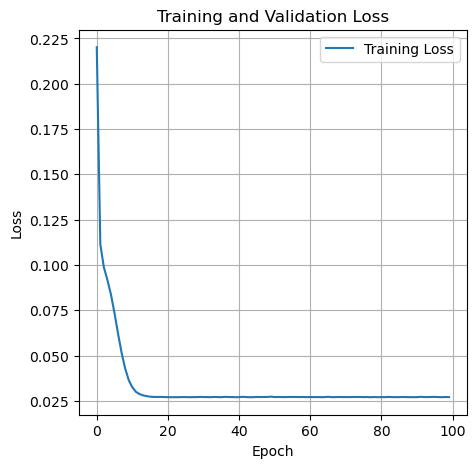

In [31]:
equity_train_losses = train_equity_model(
    equity_model, 
    dataloader,
    equity_loss_func, 
    optimizer,
    epochs=100
    )

plot_train_loss(equity_train_losses)


In [32]:
equity_model.eval()
with torch.no_grad():
    equity_emb = equity_model.hand_embedder(torch.arange(169))
    equity_emb = F.normalize(equity_emb, p=2, dim=1)

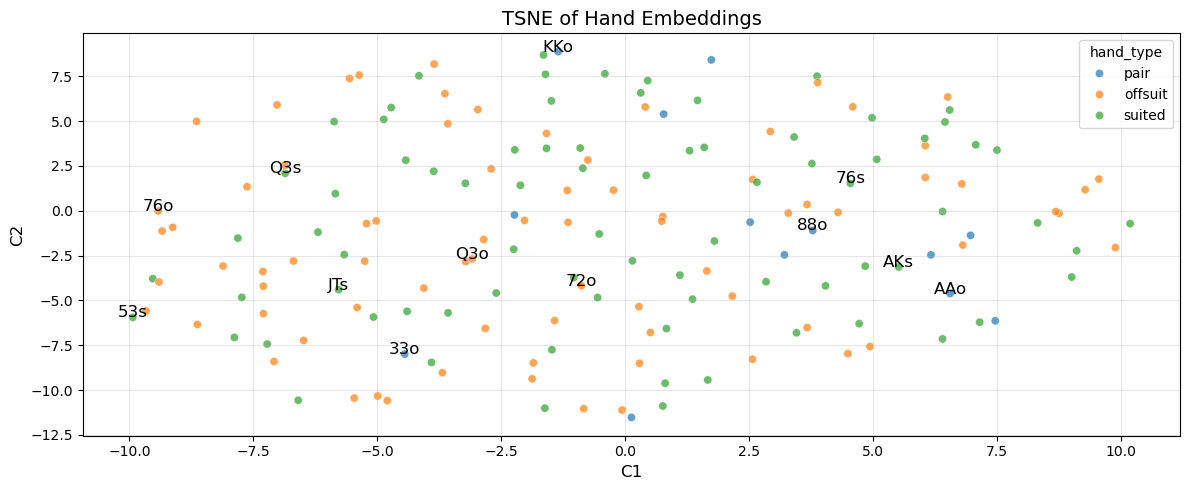

   hand         top_1         top_2         top_3       bottom_1  \
0   AAo  K5s (0.5178)  A9s (0.5075)  AQs (0.4697)  92s (-0.4834)   
1   KKo  AQs (0.6610)  K7s (0.5672)  AQo (0.5231)  63o (-0.4723)   
2   72o  74s (0.6675)  52s (0.6474)  85o (0.5600)  J3s (-0.4555)   
3   76s  T5s (0.5373)  A9o (0.5117)  42o (0.4524)  Q6o (-0.5362)   
4   76o  Q8o (0.5423)  93o (0.5360)  T2s (0.5030)  52s (-0.5625)   
5   Q3s  Q9o (0.7389)  QTs (0.6090)  J9o (0.5737)  86o (-0.4917)   
6   Q3o  98o (0.6824)  A5o (0.5760)  K9s (0.5480)  Q7s (-0.6398)   
7   88o  AJo (0.5501)  QQo (0.4841)  A9o (0.4700)  J3s (-0.4899)   
8   JTs  K8o (0.5258)  J9o (0.5036)  A5o (0.4884)  K8s (-0.5539)   
9   33o  T8s (0.6876)  A2o (0.5706)  A3o (0.5264)  98s (-0.5243)   
10  AKs  A7s (0.5597)  44o (0.5346)  K8s (0.4860)  52s (-0.5254)   
11  53s  94o (0.6498)  A8o (0.5285)  A3s (0.4942)  A4o (-0.4392)   

         bottom_2       bottom_3  
0   52o (-0.4949)  32o (-0.5265)  
1   82o (-0.5239)  J7s (-0.5645)  
2   AJo (-

In [33]:
similarity_df = analyze_embeddings(
    equity_emb, 
    hands_of_interest=['AAo','KKo','72o','76s','76o','Q3s',"Q3o",'88o','JTs','33o',"AKs","53s"],
    hand_feature_to_color='hand_type',
    figsize=(12,5)
    )

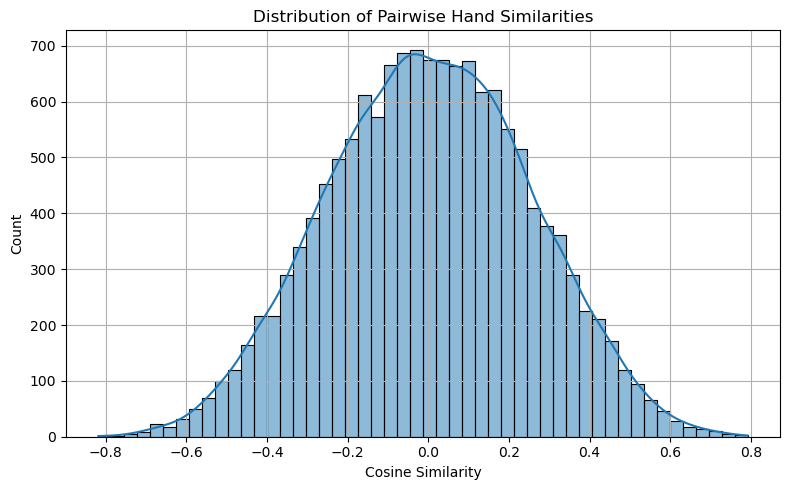

In [34]:
mask = np.triu(np.ones(similarity_df.shape), k=1).astype(bool)
pairwise_sims = similarity_df.where(mask)

all_similarities = pairwise_sims.stack().values

plt.figure(figsize=(8, 5))
sns.histplot(all_similarities, bins=50, kde=True)
plt.title("Distribution of Pairwise Hand Similarities")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
equity_matrix = pd.read_csv("../data/processed/equity_matrix.csv").set_index("hand").to_numpy()

In [36]:
evaluate_hand_hand_equity(equity_emb, equity_matrix)

{'spear_corr': np.float64(0.09117332997182216),
 'pval': np.float64(8.839755569911311e-54)}

In [18]:
prob_data = pd.read_csv('../data/processed/prob_data.csv')

In [19]:
prob_res = prob_embeddings(equity_emb, prob_data)

In [21]:
prob_res[prob_res.attribute == 'suited']

,attribute,class,accuracy,precision,recall,f1_score,support_frac,rmse
0,suited,0,1.0,1.0,1.0,1.0,0.538462,NaN
1,suited,1,1.0,1.0,1.0,1.0,0.461538,NaN


In [22]:
prob_res[prob_res.attribute == 'connectedness']

,attribute,class,accuracy,precision,recall,f1_score,support_frac,rmse
2,connectedness,0,0.946746,1.000000,1.000000,1.000000,0.076923,NaN
3,connectedness,1,0.946746,0.920000,0.884615,0.901961,0.153846,NaN
4,connectedness,2,0.946746,0.956522,0.916667,0.936170,0.142012,NaN
5,connectedness,3,0.946746,0.956522,1.000000,0.977778,0.130178,NaN
6,connectedness,4,0.946746,0.947368,0.900000,0.923077,0.118343,NaN
7,connectedness,5,0.946746,0.900000,1.000000,0.947368,0.106509,NaN
8,connectedness,6,0.946746,0.875000,0.875000,0.875000,0.094675,NaN
9,connectedness,7,0.946746,1.000000,1.000000,1.000000,0.059172,NaN
10,connectedness,8,0.946746,1.000000,1.000000,1.000000,0.047337,NaN
11,connectedness,9,0.946746,1.000000,1.000000,1.000000,0.035503,NaN


In [23]:
prob_res[prob_res.attribute == 'pair']

,attribute,class,accuracy,precision,recall,f1_score,support_frac,rmse
14,pair,0,0.994083,0.993631,1.000000,0.996805,0.923077,NaN
15,pair,1,0.994083,1.000000,0.923077,0.960000,0.076923,NaN


In [24]:
prob_res[prob_res.attribute == 'broadway']

,attribute,class,accuracy,precision,recall,f1_score,support_frac,rmse
60,broadway,0,1.0,1.0,1.0,1.0,0.378698,NaN
61,broadway,1,1.0,1.0,1.0,1.0,0.473373,NaN
62,broadway,2,1.0,1.0,1.0,1.0,0.147929,NaN


In [25]:
prob_res[prob_res.attribute == 'connector']

,attribute,class,accuracy,precision,recall,f1_score,support_frac,rmse
72,connector,0,0.994083,0.993056,1.000000,0.996516,0.846154,NaN
73,connector,1,0.994083,1.000000,0.961538,0.980392,0.153846,NaN


In [26]:
prob_res.sort_values(by='accuracy')

,attribute,class,accuracy,precision,recall,f1_score,support_frac,rmse
3,connectedness,1,0.946746,0.920000,0.884615,0.901961,0.153846,NaN
2,connectedness,0,0.946746,1.000000,1.000000,1.000000,0.076923,NaN
5,connectedness,3,0.946746,0.956522,1.000000,0.977778,0.130178,NaN
4,connectedness,2,0.946746,0.956522,0.916667,0.936170,0.142012,NaN
6,connectedness,4,0.946746,0.947368,0.900000,0.923077,0.118343,NaN
...,...,...,...,...,...,...,...,...
59,pos7_play8,NaN,NaN,NaN,NaN,NaN,NaN,0.208684
60,pos7_play9,NaN,NaN,NaN,NaN,NaN,NaN,0.213559
61,pos8_play10,NaN,NaN,NaN,NaN,NaN,NaN,0.220219
62,pos8_play9,NaN,NaN,NaN,NaN,NaN,NaN,0.210850


In [25]:
# prob_res.to_csv("results/prob_preflop_equitydiff16.csv", index=False)
# similarity_df.reset_index().rename({"index":'hand'},axis=1).to_csv(
#     "results/sim_preflop_equitydiff16.csv", index=False)

In [ ]:
# save_model_and_embeddings(
#     equity_emb,
#     'preflop_equitydiff_embeddings',
#     equity_model,
#     "preflop_equitydiff_encoder_weights"
#     )